---
# Texas Used Cars Regression Project
---

Adam Talbot - 10.14.21

<img src="https://s19538.pcdn.co/wp-content/uploads/2018/08/Car-Gurus-Logo.jpg" alt="Car Gurus" title="Car Gurus Logo" width="600" height="300" />

---
## Executive Summary
---

**Goals:**
- Find predictors of sales price for used cars in Texas
- Construct a ML regression model that accurately predicts sales price
- Complete end-to-end ML project encompassing all phases of DS pipeline
- Document code, process (data acquistion, preparation, exploratory data analysis and statistical testing, modeling, and model evaluation), findings, and key takeaways in a Jupyter Notebook report
- Create modules as necessary that make my process repeateable
- Include all work in github repo with README to provide high level overview and instructions for replication

 **Conclusions/Takaways:**
- The best drivers identified via exploration were:
    - *Enter them here when found*
- Best predictors identified via modeling were:
    - *Enter them here when found*
- Best-peforming model outperformed basline by:
    - *RMSE difference for test vs baseline*
    - *R$^2$ improvement over baseline*

**Next Steps/Recommendations:**
- *Try more combinations of features in model to see if model performance can be improved/more drivers can be indentified*
- *Look into creating individual models for subgroups*
- **Add more here**

---
## Plan
---

- [x] Create README.md with data dictionary, project and business goals, come up with initial hypotheses.
- [x] Acquire data from Kaggle, save to local .csv and create a function to automate this process. Save the function in an acquire.py file to import into the Final Report Notebook.
- [x] Clean and prepare data for the first iteration through the pipeline, MVP preparation. Create a function to automate the process, store the function in a prepare.py module, and prepare data in Final Report Notebook by importing and using the funtion.
- [x] Clearly define at least two hypotheses, set an alpha, run the statistical tests needed, reject or fail to reject the Null Hypothesis, and document findings and takeaways.
- [x] Establish a baseline accuracy and document well.
- [x] Train several different regression models.
- [x] Evaluate models on train and validate datasets.
- [x] Choose the model with that performs the best and evaluate that single model on the test dataset.
- [x] Document conclusions, takeaways, and next steps in the Final Report Notebook.

---
## Imports
---

In [1]:
# standard imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# sklearn imports
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# supress scientific notation
np.set_printoptions(suppress=True)

# Custom module imports
import acquire as a
import prepare as p
import explore as e
import evaluate as ev

# matplotlib settings
plt.rc('font', size=12)
plt.rc('figure', figsize=(15, 7))
pd.options.display.float_format = '{:.2f}'.format

---
## Acquire
---

In [2]:
# use function from wrangle module to acquire needed data, see wrangle.py for code
df = a.get_tx_car_data()

In [3]:
df.head(1)

,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,...,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
139229,JHMFC1F73JX018575,37.4 in,NaN,NaN,NaN,Sedan,NaN,Fort Worth,32.00,NaN,...,CVT,Continuously Variable Transmission,t76411,Touring,NaN,FWD,Front-Wheel Drive,106.3 in,70.8 in,2018


In [4]:
df.shape

(122842, 66)

### Takeaways:
- Have some outliers/erroneous data in several numeric columns
- Lots of nulls in several columns
- I am starting with a df with a shape of (122842, 66)
- Description of initial data pull:
    - Only pulled records for cars sold in the 7 largest cities (population) in TX
        - Houston, San Antonio, Dallas, Austin, El Paso, Arlington, and Fort Worth

---
## Prepare
---

### Clean

In [5]:
# use function to clean data, see prepare.py for code
df = p.clean_cars(df)
df.head()

,back_legroom,body_type,city,city_fuel_economy,engine_displacement,franchise_dealer,front_legroom,fuel_tank_volume,fuel_type,height,...,longitude,make_name,maximum_seating,mileage,price,transmission,wheel_system,wheelbase,width,year
0,37.40,Sedan,Fort Worth,32.00,1500.00,0,42.30,12.40,Gasoline,55.70,...,-97.46,Honda,5.00,16600.00,18990.00,CVT,FWD,106.30,70.80,2018
1,34.50,Hatchback,Austin,27.00,1500.00,1,41.30,10.60,Gasoline,60.00,...,-97.76,Honda,5.00,103208.00,6488.00,A,FWD,98.40,66.70,2012
2,35.50,Wagon,Arlington,29.00,2000.00,0,41.10,14.50,Diesel,59.20,...,-97.06,Other,5.00,52882.00,10999.00,A,FWD,101.50,70.10,2014
4,32.90,SUV / Crossover,Houston,23.00,4000.00,0,41.70,23.00,Gasoline,71.50,...,-95.25,Toyota,7.00,40817.00,29995.00,A,4WD,109.80,75.80,2019
5,36.20,Sedan,El Paso,30.00,1800.00,0,42.00,13.20,Gasoline,56.50,...,-106.39,Honda,5.00,76500.00,11500.00,CVT,FWD,105.10,69.00,2015


In [6]:
df.shape

(91114, 26)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91114 entries, 0 to 122840
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   back_legroom          91114 non-null  float64
 1   body_type             91114 non-null  object 
 2   city                  91114 non-null  object 
 3   city_fuel_economy     91114 non-null  float64
 4   engine_displacement   91114 non-null  float64
 5   franchise_dealer      91114 non-null  int64  
 6   front_legroom         91114 non-null  float64
 7   fuel_tank_volume      91114 non-null  float64
 8   fuel_type             91114 non-null  object 
 9   height                91114 non-null  float64
 10  highway_fuel_economy  91114 non-null  float64
 11  horsepower            91114 non-null  float64
 12  is_new                91114 non-null  int64  
 13  latitude              91114 non-null  float64
 14  length                91114 non-null  float64
 15  listing_color     

In [8]:
cat_cols = df.select_dtypes('object').columns.tolist()

for cat in cat_cols:
    print(cat)
    print('-----------------')
    print(df[cat].value_counts(normalize=True))
    print('-----------------\n')

body_type
-----------------
SUV / Crossover   0.56
Sedan             0.30
Pickup Truck      0.04
Coupe             0.03
Minivan           0.03
Hatchback         0.02
Wagon             0.01
Convertible       0.00
Van               0.00
Name: body_type, dtype: float64
-----------------

city
-----------------
Houston       0.35
San Antonio   0.21
Austin        0.12
Dallas        0.11
El Paso       0.08
Arlington     0.07
Fort Worth    0.06
Name: city, dtype: float64
-----------------

fuel_type
-----------------
Gasoline                 0.96
Flex Fuel Vehicle        0.03
Diesel                   0.01
Hybrid                   0.00
Electric                 0.00
Biodiesel                0.00
Compressed Natural Gas   0.00
Name: fuel_type, dtype: float64
-----------------

listing_color
-----------------
WHITE     0.20
BLACK     0.20
UNKNOWN   0.14
GRAY      0.14
SILVER    0.14
BLUE      0.08
RED       0.08
BROWN     0.01
GREEN     0.01
ORANGE    0.00
GOLD      0.00
TEAL      0.00
YELLOW    0

#### Cleaning Performed:
- Reset index for subset of data selected from raw data
- Dropped duplicate rows
- Dropped all columns and rows with more than 50% of data missing
- Pulled numbers from strings for various measurement columns
- Converted boolean columns to 1 or 0
- Simplified some columns with many categories by adding "Other" category
- Dropped columns that had too many columns, were redundant, or weren't useful for my objectives with this project
- Imputed remaining null values using mean for continuous variables and mode for categorical variables
- Removed outliers for columns where needed using Tukey's Method and a k-value of 2

#### Takeaways:
- Current shape of data: (91114, 26)

---
### Encode, Split and Scale for Modeling

In [9]:
# encode
df_encoded = pd.get_dummies(data=df, columns=cat_cols)
df_encoded.head()

,back_legroom,city_fuel_economy,engine_displacement,franchise_dealer,front_legroom,fuel_tank_volume,height,highway_fuel_economy,horsepower,is_new,...,make_name_Toyota,transmission_A,transmission_CVT,transmission_Dual Clutch,transmission_M,wheel_system_4WD,wheel_system_4X2,wheel_system_AWD,wheel_system_FWD,wheel_system_RWD
0,37.40,32.00,1500.00,0,42.30,12.40,55.70,42.00,174.00,0,...,0,0,1,0,0,0,0,0,1,0
1,34.50,27.00,1500.00,1,41.30,10.60,60.00,33.00,117.00,0,...,0,1,0,0,0,0,0,0,1,0
2,35.50,29.00,2000.00,0,41.10,14.50,59.20,39.00,140.00,0,...,0,1,0,0,0,0,0,0,1,0
4,32.90,23.00,4000.00,0,41.70,23.00,71.50,30.00,270.00,0,...,1,1,0,0,0,1,0,0,0,0
5,36.20,30.00,1800.00,0,42.00,13.20,56.50,39.00,143.00,0,...,0,0,1,0,0,0,0,0,1,0


In [10]:
# split
train_mod, val_mod, test_mod = p.split_80(df_encoded)

Train Proportion: 0.80 (72981 rows)
Validate Proportion: 0.10 (9021 rows)    
Test Proportion: 0.10 (9112 rows)


In [11]:
# scale
cols_to_scale = [
    'back_legroom',
    'city_fuel_economy',
    'engine_displacement',
    'front_legroom',
    'fuel_tank_volume',
    'height',
    'highway_fuel_economy',
    'horsepower',
    'latitude',
    'length',
    'longitude',
    'maximum_seating',
    'mileage',
    'wheelbase',
    'width',
    'year']

train_mod_scaled, val_mod_scaled, test_mod_scaled = p.scale(train_mod, val_mod, test_mod, MinMaxScaler(), cols_to_scale)

train_mod_scaled.head()

,franchise_dealer,is_new,price,body_type_Convertible,body_type_Coupe,body_type_Hatchback,body_type_Minivan,body_type_Pickup Truck,body_type_SUV / Crossover,body_type_Sedan,...,highway_fuel_economy_scaled,horsepower_scaled,latitude_scaled,length_scaled,longitude_scaled,maximum_seating_scaled,mileage_scaled,wheelbase_scaled,width_scaled,year_scaled
103196,1,1,24832.00,0,0,0,0,0,0,1,...,0.61,0.33,0.03,0.47,0.31,0.40,0.00,0.29,0.16,0.90
36985,0,0,16998.00,0,0,0,1,0,0,0,...,0.15,0.45,0.06,0.71,0.25,0.80,0.40,0.64,0.71,0.80
107410,1,1,35603.00,0,0,0,0,0,0,1,...,0.48,0.42,0.02,0.55,0.32,0.40,0.00,0.43,0.25,0.90
19908,0,0,8990.00,0,0,1,0,0,0,0,...,0.70,0.14,0.07,0.17,0.25,0.40,0.52,0.19,0.04,0.60
35809,1,1,23352.00,0,0,0,0,0,0,1,...,0.82,0.16,0.03,0.47,0.23,0.40,0.00,0.29,0.16,0.90


---
### Split for Exploration

In [12]:
train_exp, val_exp, test_exp = p.split_80(df)

Train Proportion: 0.80 (72981 rows)
Validate Proportion: 0.10 (9021 rows)    
Test Proportion: 0.10 (9112 rows)


---
## Explore 
---

### Univariate

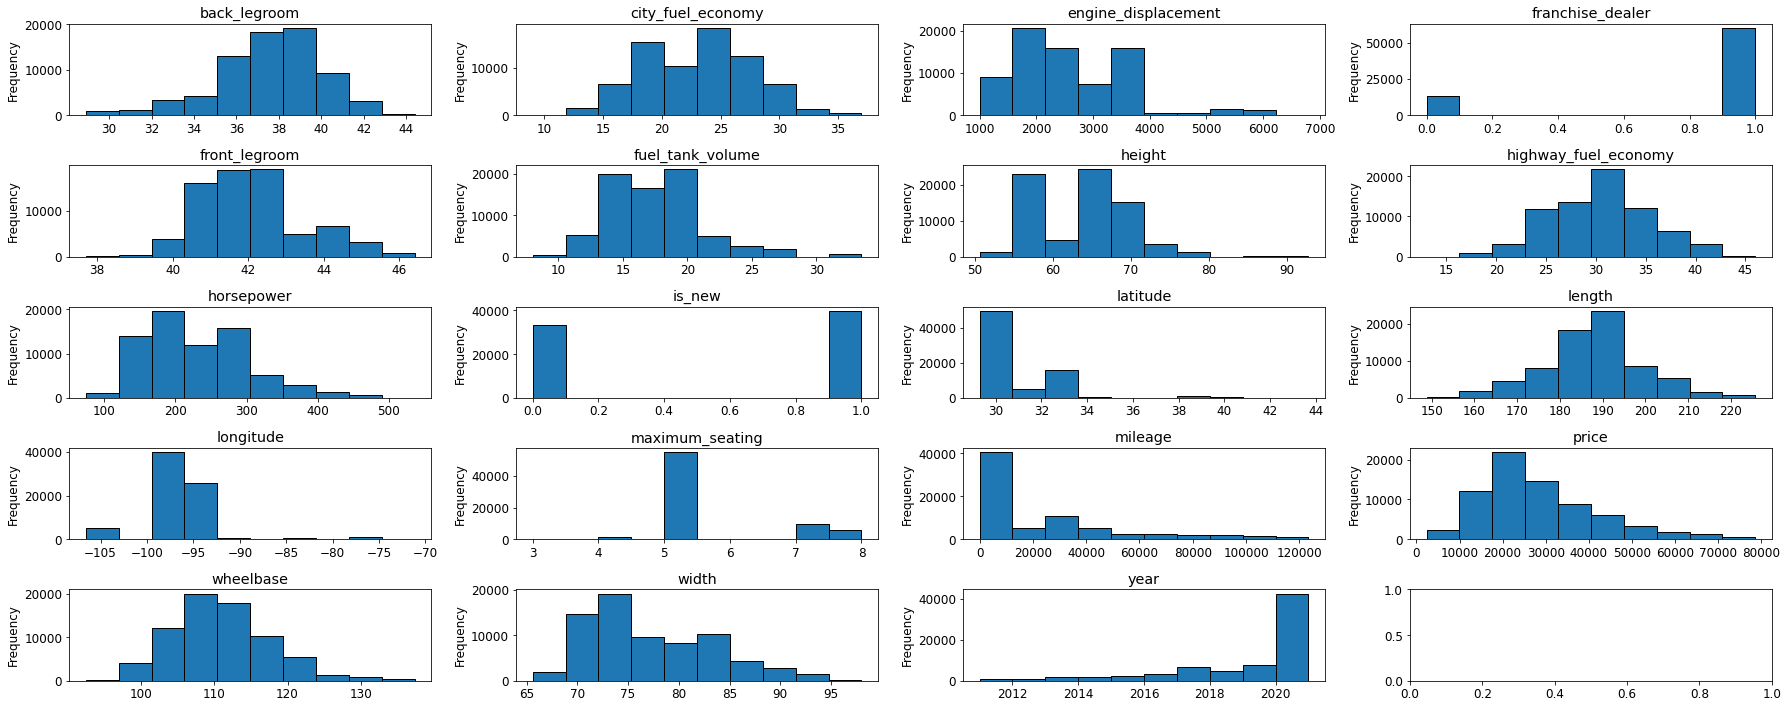

In [13]:
# let's take a quick look at the distributions of the continuous variables
fig, axs = plt.subplots(5, 4, sharey=False, figsize=(25, 10))
axe = axs.ravel()
for i, c in enumerate(train_exp.select_dtypes('number').columns):
    train_exp[c].plot.hist(ax=axe[i],title=c, ec='black')
    plt.tight_layout()

#### Takeaways:
- Some distributions look normal, some not as much
- Will use parametric and non-parametric tests accordingly

### Bivariate

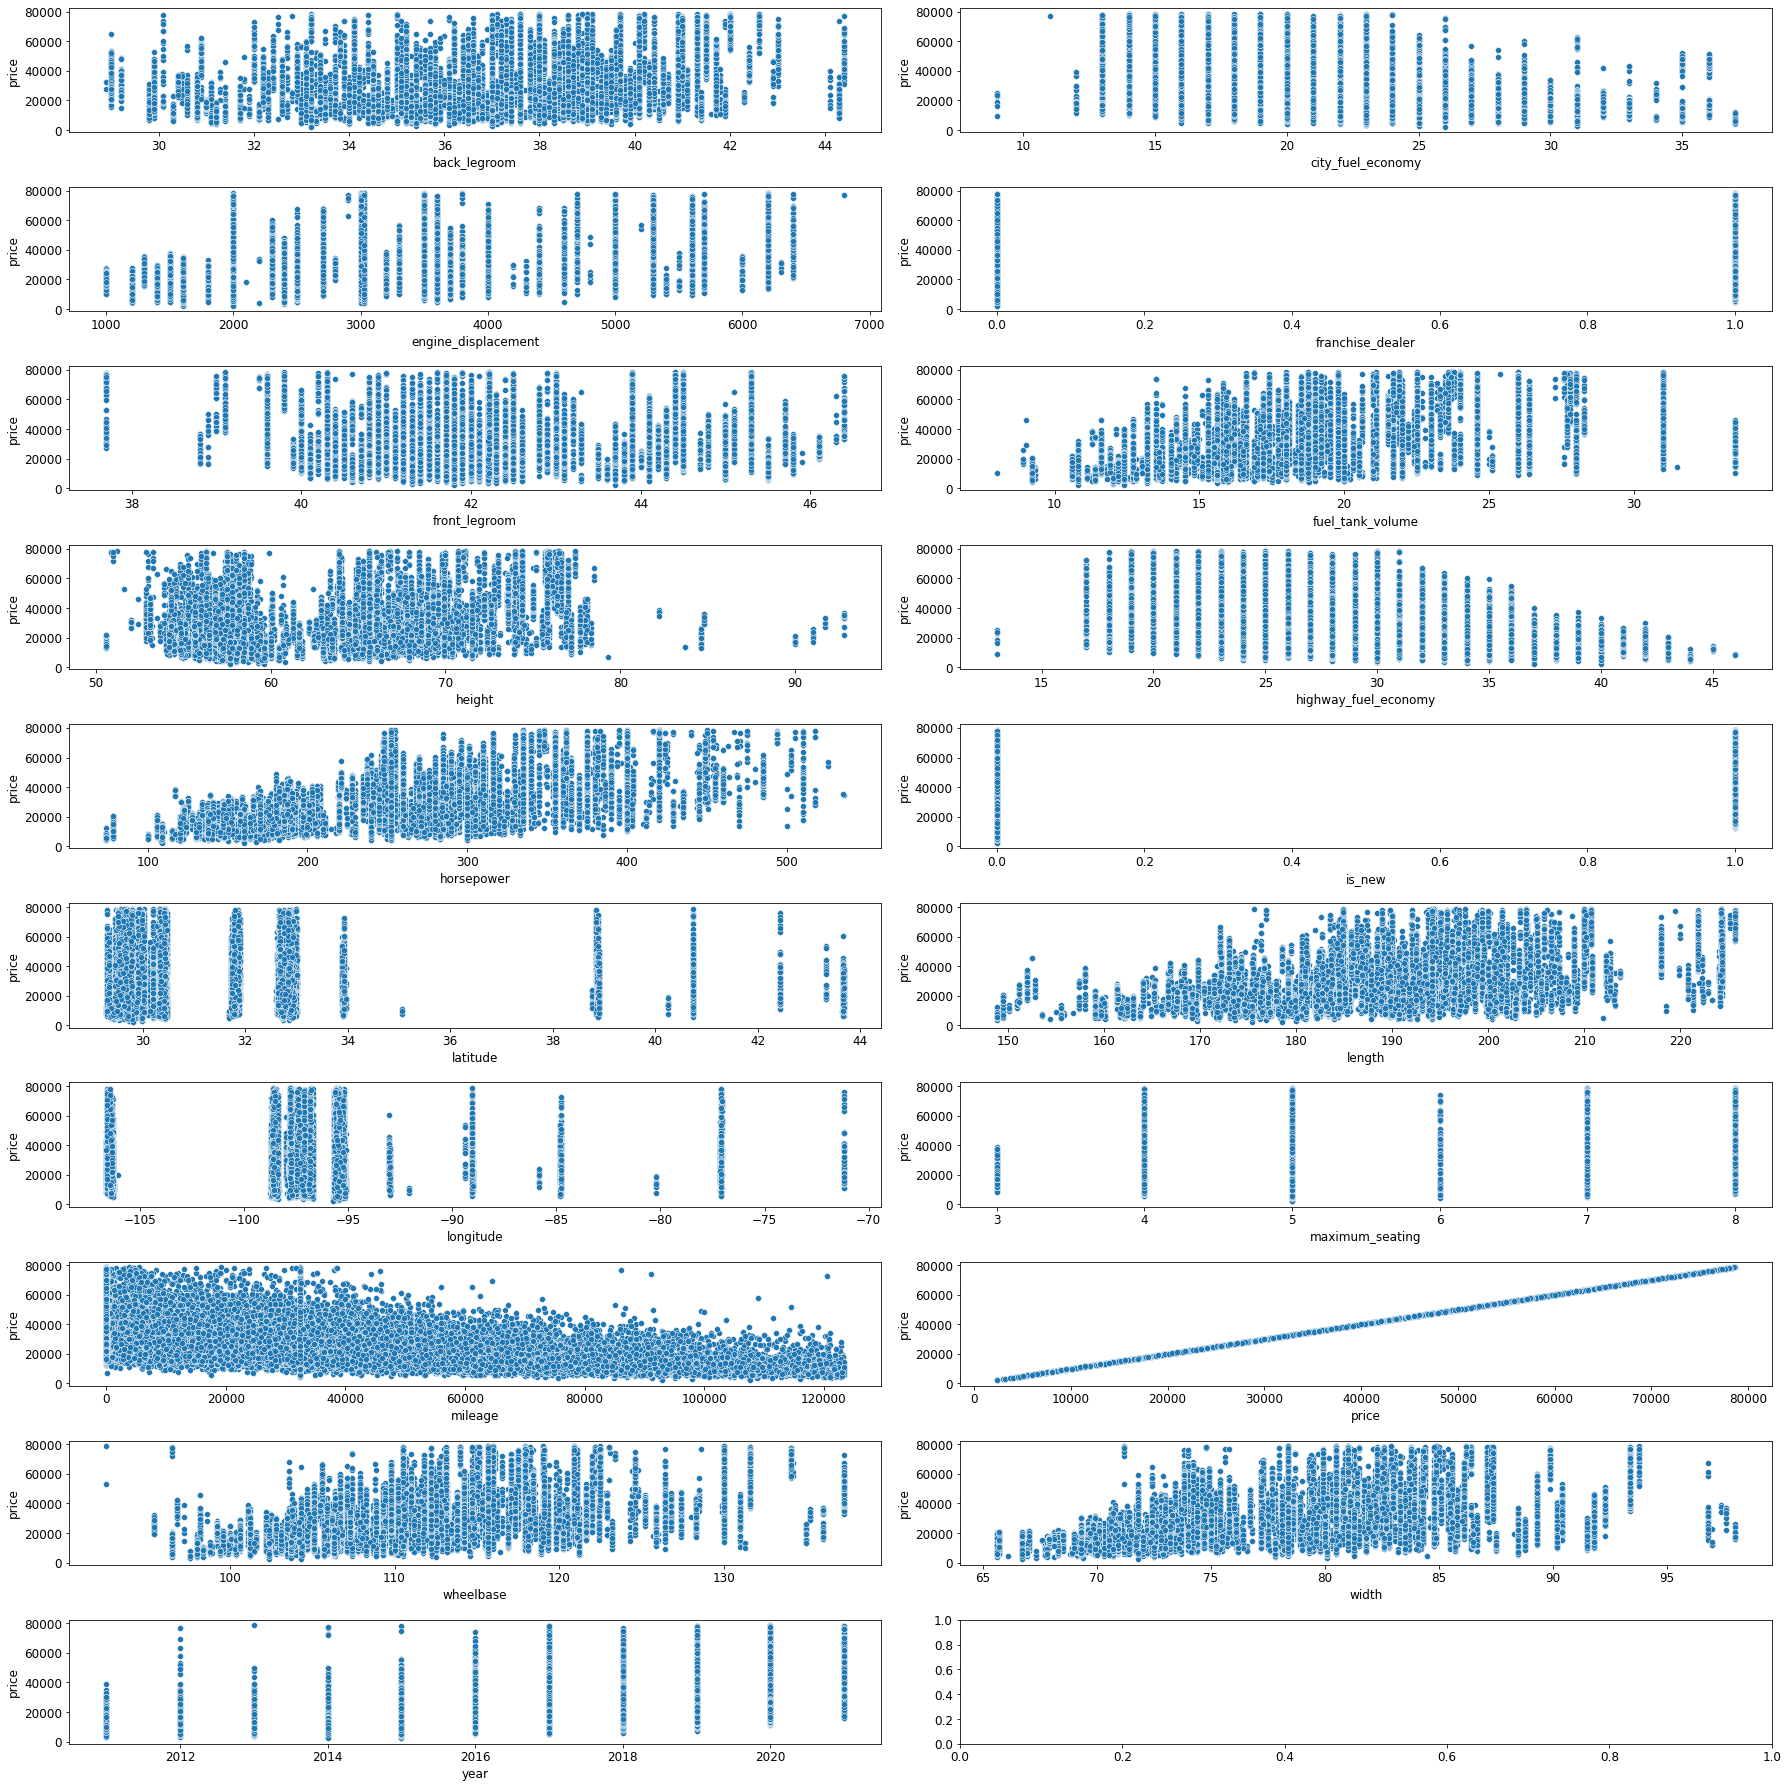

In [14]:
# let's take a look at all other continuous variables compared to target
fig, axs = plt.subplots(10, 2, sharey=False, figsize=(25, 25))
axe = axs.ravel()
for i, c in enumerate(train_exp.select_dtypes('number').columns):
    sns.scatterplot(x=train_exp[c], y=train_exp.price, ax=axe[i])
    plt.tight_layout()

#### Takeaways:
- Positive correlations between price and:
    - back legroom
    - engine displacement
    - fuel tank volume
    - horsepower
    - length
    - maximum seating
    - wheelbase
    - width
    - year
- Negative correlations between price and:
    - city fuel economy
    - highway fuel economy
    - mileage

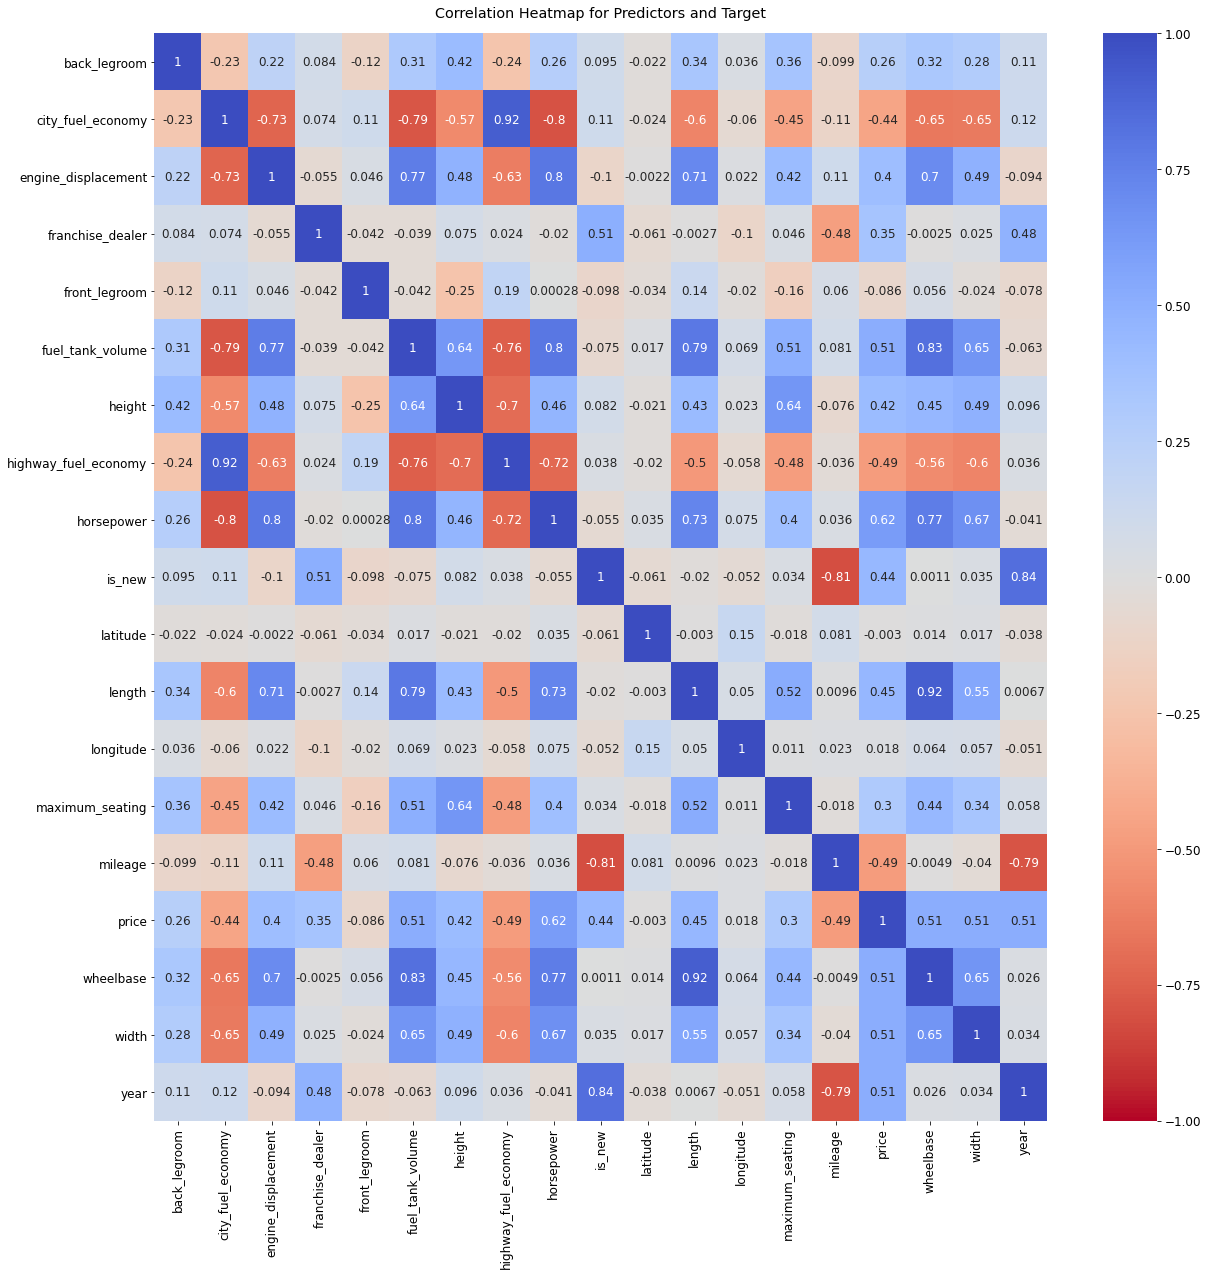

In [15]:
# heatmap of correlations for all columns
plt.figure(figsize=(20, 20))
heatmap = sns.heatmap(train_exp.corr(method='spearman'), annot=True, cmap='coolwarm_r', vmin=-1, vmax=1, center=0)
heatmap.set_title('Correlation Heatmap for Predictors and Target', pad=16);

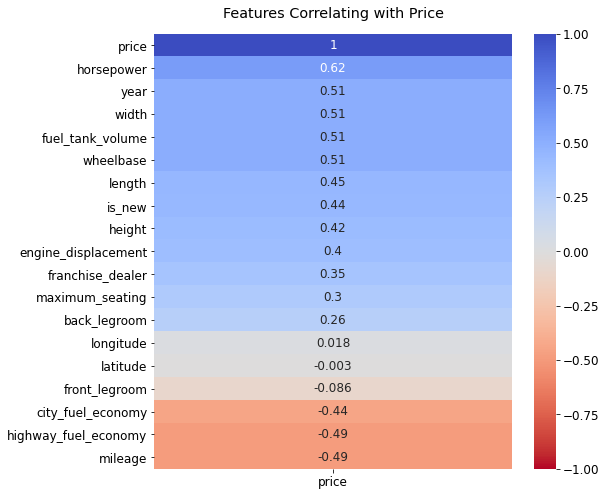

In [16]:
# heatmap of correlations for features and target
plt.figure(figsize=(8,8))
heatmap = sns.heatmap(train_exp.corr(method='spearman')[['price']].sort_values(by='price', ascending=False), annot=True, cmap='coolwarm_r', vmin=-1, vmax=1 );
heatmap.set_title('Features Correlating with Price', pad=16);

#### Takeaways:
- Some variables are highly correlated with each other as see above
- Some variables are more correlated with target than others as seen above

In [24]:
cat_cols = train_exp.select_dtypes('object').columns.tolist()
cat_cols.append('is_new')
cat_cols.append('franchise_dealer')

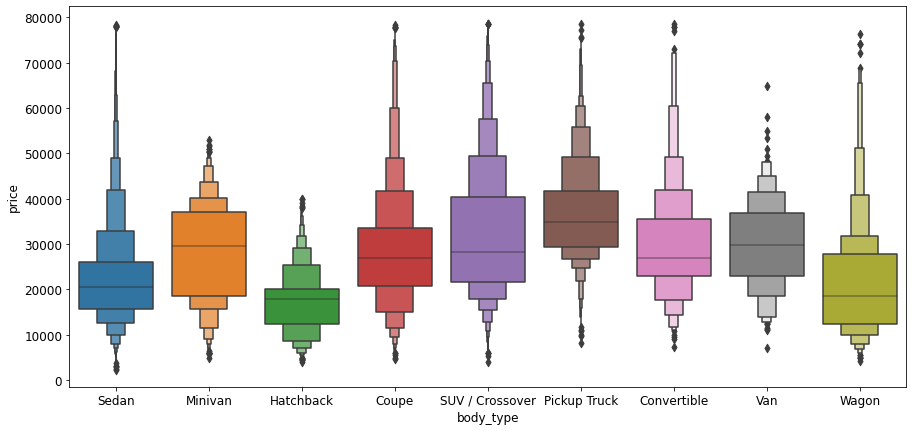

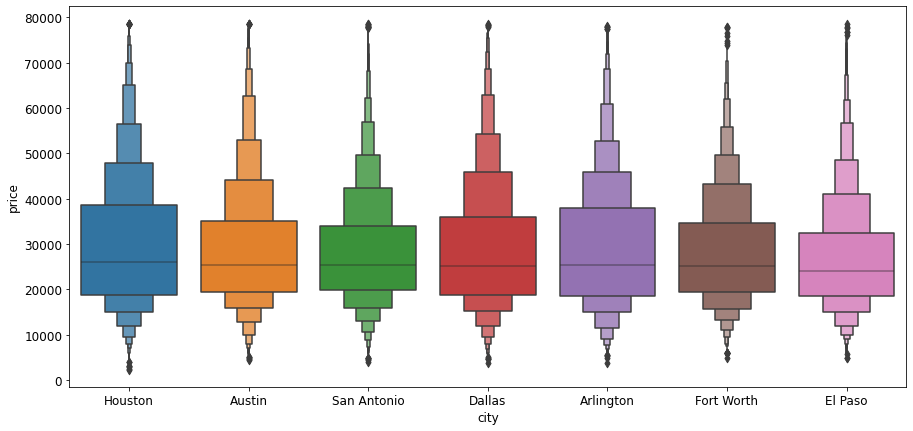

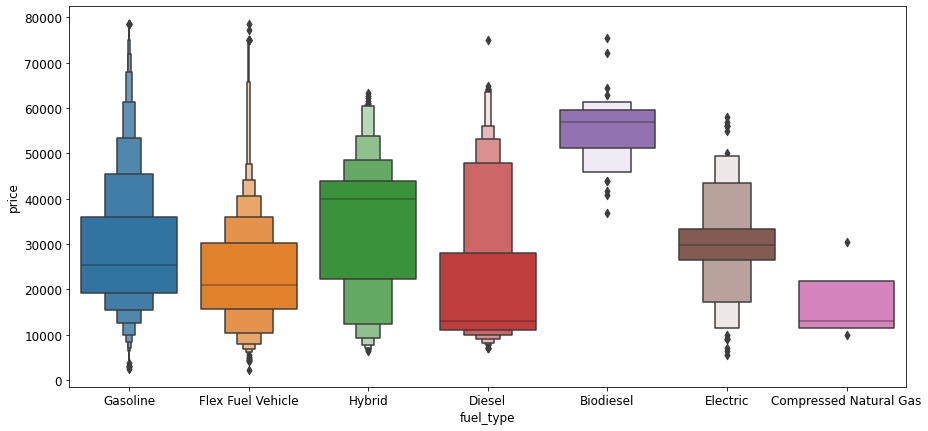

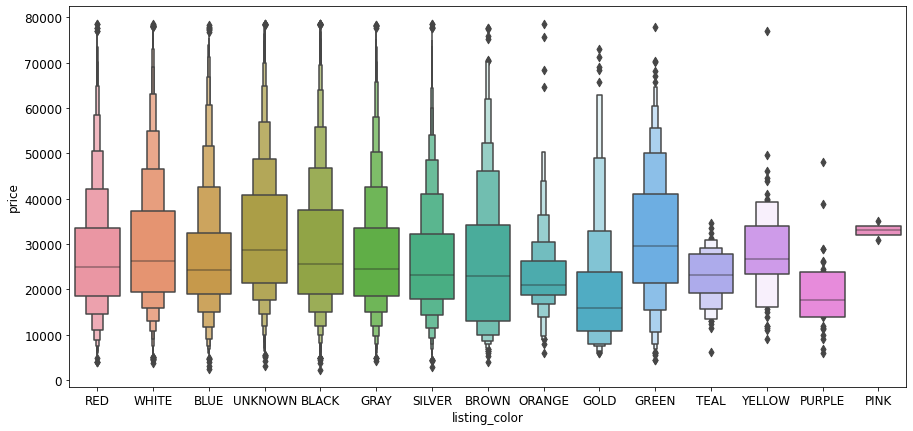

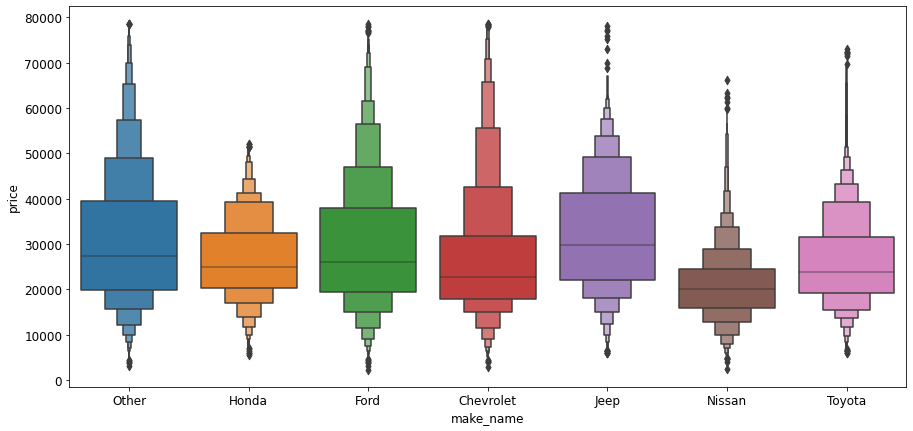

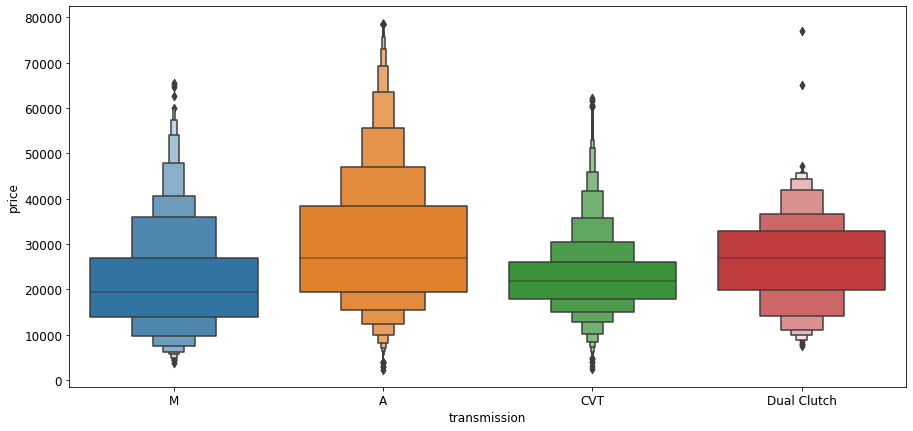

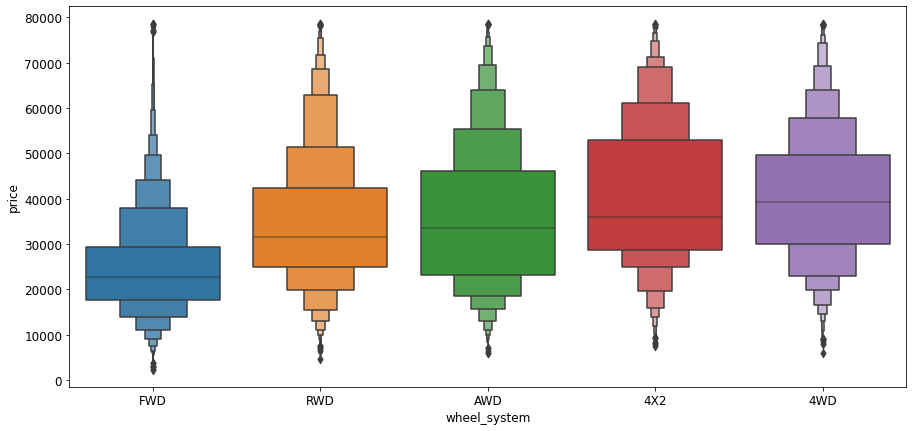

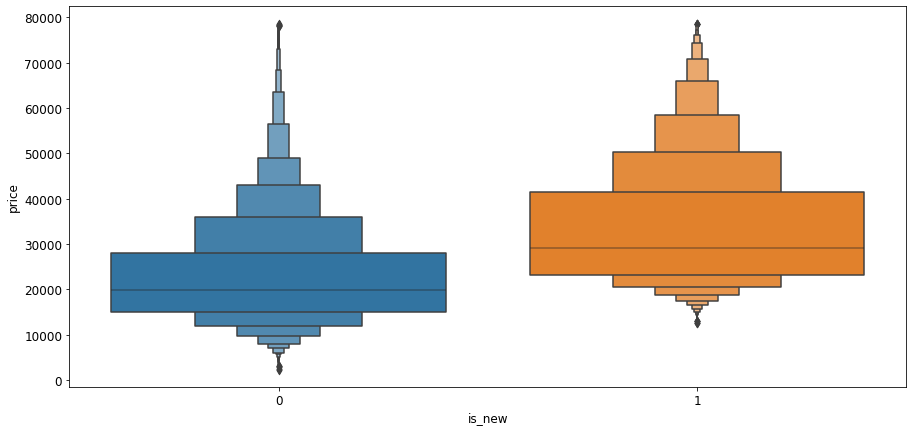

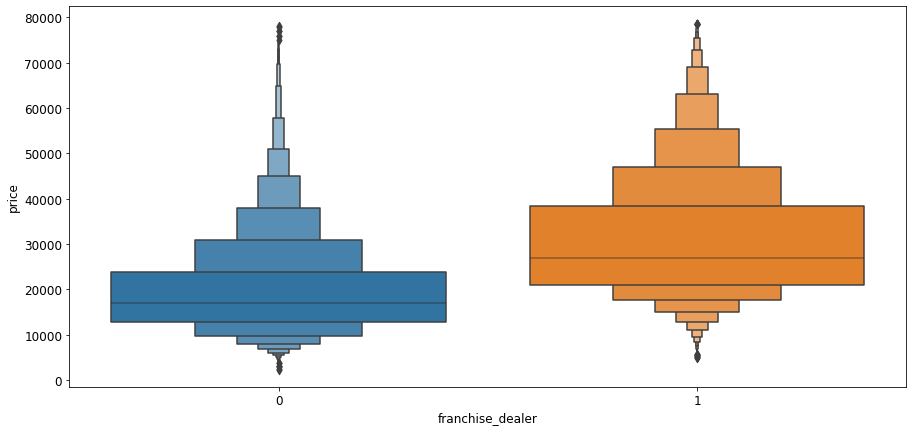

In [34]:
for col in cat_cols:
    sns.boxenplot(x=train_exp[col], y=train_exp.price)
    plt.show()

#### Takeaways:
- All of these categorical features appear to have a relationship with price except city

### Multivariate

---
### X and y

In [35]:
# split into X and y for all splits
X_train = train_mod.drop(columns='price')
y_train = train_mod.price
X_validate = val_mod.drop(columns='price')
y_validate = val_mod.price
X_test = test_mod.drop(columns='price')
y_test = test_mod.price

---
### Additional Feature Analysis

#### SelectKBest

In [39]:
e.select_kbest(X_train, y_train, 10)

['city_fuel_economy',
 'fuel_tank_volume',
 'height',
 'highway_fuel_economy',
 'horsepower',
 'length',
 'mileage',
 'wheelbase',
 'width',
 'year']

#### RFE

In [53]:
e.show_rfe_feature_ranking(X_train, y_train).head(50)

fuel_type_Biodiesel                  1
fuel_type_Compressed Natural Gas     2
wheel_system_FWD                     3
is_new                               4
listing_color_PINK                   5
franchise_dealer                     6
fuel_type_Hybrid                     7
transmission_CVT                     8
body_type_SUV / Crossover            9
body_type_Pickup Truck              10
transmission_Dual Clutch            11
body_type_Van                       12
body_type_Hatchback                 13
make_name_Honda                     14
body_type_Convertible               15
make_name_Other                     16
make_name_Toyota                    17
wheel_system_4X2                    18
listing_color_TEAL                  19
year                                20
city_Fort Worth                     21
transmission_A                      22
body_type_Coupe                     23
fuel_type_Flex Fuel Vehicle         24
fuel_tank_volume                    25
body_type_Minivan        

### Explore Takeaways:
- *need to add stuff here*


---
## Model/Evaluate
---

### Target Distribution

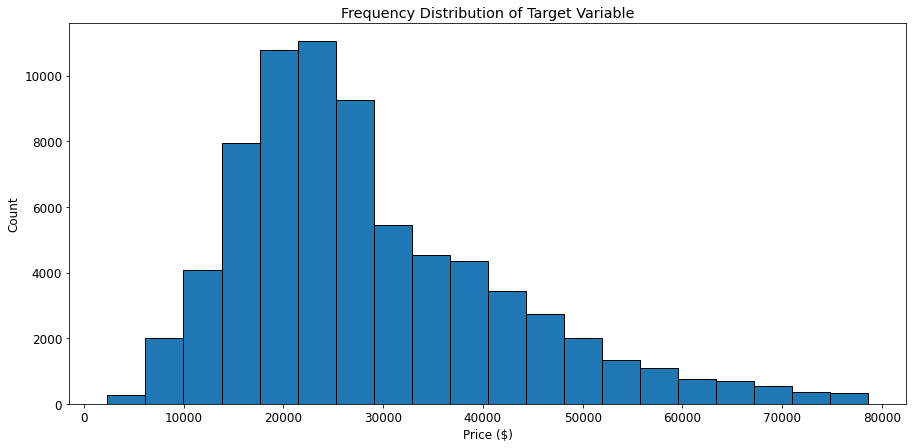

In [52]:
plt.hist(y_train, edgecolor='black', bins=20)
plt.title('Frequency Distribution of Target Variable')
plt.xlabel('Price ($)')
plt.ylabel('Count');

***Not completely normal, this could inform our model algorithm selection decision***

### Baseline

In [63]:
target = 'price'

In [64]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Predict baseline_mean
baseline_mean = y_train[target].mean()
y_train['baseline_mean'] = baseline_mean
y_validate['baseline_mean'] = baseline_mean

# Predict baseline_median
baseline_median = y_train[target].median()
y_train['baseline_median'] = baseline_median
y_validate['baseline_median'] = baseline_median

In [65]:
# create empty df to start appending to
metric_df = pd.DataFrame()

In [66]:
# get metrics for baseline mean model
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.baseline_mean, 
                           y_validate[target], 
                           y_validate.baseline_mean, 
                           'Baseline Mean', 
                           metric_df)

In [67]:
# get metrics for baseline median model
metric_df = ev.make_metric_df(y_train[target], 
                           y_train.baseline_median, 
                           y_validate[target], 
                           y_validate.baseline_median, 
                           'Baseline Median', 
                           metric_df)

In [68]:
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,Baseline Mean,13617.83,13544.59,73.24,0.00,0.00,0.00
1,Baseline Median,13991.70,13931.13,60.56,0.00,0.00,0.00


### LinearRegression (OLS)

In [59]:
# make model
ols = LinearRegression(normalize=True)

# fit model
ols.fit(X_train, y_train.log_error)

# Make prediction for train and validate
y_train['ols_y_pred'] = ols.predict(X_train)
y_validate['ols_y_pred'] = ols.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.ols_y_pred, 
                           y_validate.log_error, 
                           y_validate.ols_y_pred, 
                           'OLS', 
                           metric_df)

### LassoLars

In [60]:
# create the model
lars = LassoLars(alpha=1)

# fit the model
lars.fit(X_train, y_train.log_error)

# predict train
y_train['lars_y_pred_alpha_1'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_1'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.lars_y_pred_alpha_1, 
                           y_validate.log_error, 
                           y_validate.lars_y_pred_alpha_1, 
                           'lasso_alpha_1', 
                           metric_df)

In [61]:
# create the model
lars = LassoLars(alpha=2)

# fit the model
lars.fit(X_train, y_train.log_error)

# predict train
y_train['lars_y_pred_alpha_2'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_2'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.lars_y_pred_alpha_2, 
                           y_validate.log_error, 
                           y_validate.lars_y_pred_alpha_2, 
                           'lasso_alpha_2', 
                           metric_df)

In [62]:
# create the model
lars = LassoLars(alpha=3)

# fit the model
lars.fit(X_train, y_train.log_error)

# predict train
y_train['lars_y_pred_alpha_3'] = lars.predict(X_train)

# predict validate
y_validate['lars_y_pred_alpha_3'] = lars.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.lars_y_pred_alpha_3, 
                           y_validate.log_error, 
                           y_validate.lars_y_pred_alpha_3, 
                           'lasso_alpha_3', 
                           metric_df)

###  TweedieRegressor (GLM)

In [63]:
# create the model
glm = TweedieRegressor(power=0, alpha=0)

# fit the model
glm.fit(X_train, y_train.log_error)

# predict train
y_train['glm_y_pred_normal'] = glm.predict(X_train)

# predict validate
y_validate['glm_y_pred_normal'] = glm.predict(X_validate)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.glm_y_pred_normal, 
                           y_validate.log_error, 
                           y_validate.glm_y_pred_normal, 
                           'glm_normal', 
                           metric_df)

### Polynomial Regression

#### PolynomialFeatures

In [64]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate
X_validate_degree2 = pf.transform(X_validate)

#### LinearRegression

In [65]:
# create the model
lm2 = LinearRegression(normalize=True)

# fit the model
lm2.fit(X_train_degree2, y_train.log_error)

# predict train
y_train['lm2_y_pred'] = lm2.predict(X_train_degree2)

# predict validate
y_validate['lm2_y_pred'] = lm2.predict(X_validate_degree2)

# get metrics
metric_df = ev.make_metric_df(y_train.log_error, 
                           y_train.lm2_y_pred, 
                           y_validate.log_error, 
                           y_validate.lm2_y_pred, 
                           'lm2', 
                           metric_df)

In [66]:
### Metric Dataframe
metric_df

,model,RMSE_train,RMSE_validate,RMSE_diff,R2_train,R2_validate,R2_diff
0,baseline_mean,0.1586,0.1693,-0.0108,0.0000,0.0000,0.0000
1,OLS,0.1583,0.1692,-0.0109,0.0032,0.0018,0.0014
2,lasso_alpha_1,0.1586,0.1693,-0.0108,0.0000,0.0000,0.0000
3,lasso_alpha_2,0.1586,0.1693,-0.0108,0.0000,0.0000,0.0000
4,lasso_alpha_3,0.1586,0.1693,-0.0108,0.0000,0.0000,0.0000
5,glm_normal,0.1583,0.1692,-0.0108,0.0032,0.0021,0.0011
6,lm2,0.1576,0.1696,-0.0120,0.0120,-0.0035,0.0154


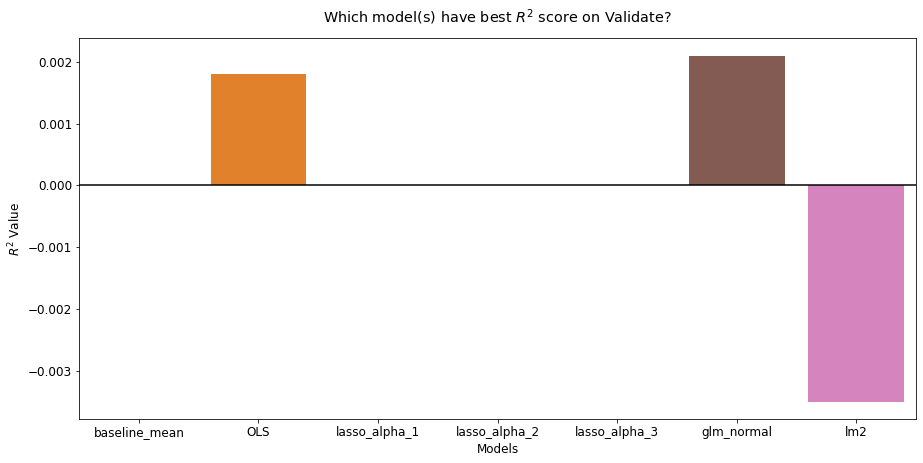

In [67]:
# Make a plot to visualize results
sns.barplot(y=metric_df.R2_validate, x=metric_df.model)
plt.title('Which model(s) have best $R^2$ score on Validate?', pad=16)
plt.xlabel('Models')
plt.ylabel('$R^2$ Value')
plt.axhline(y=0, color='black');

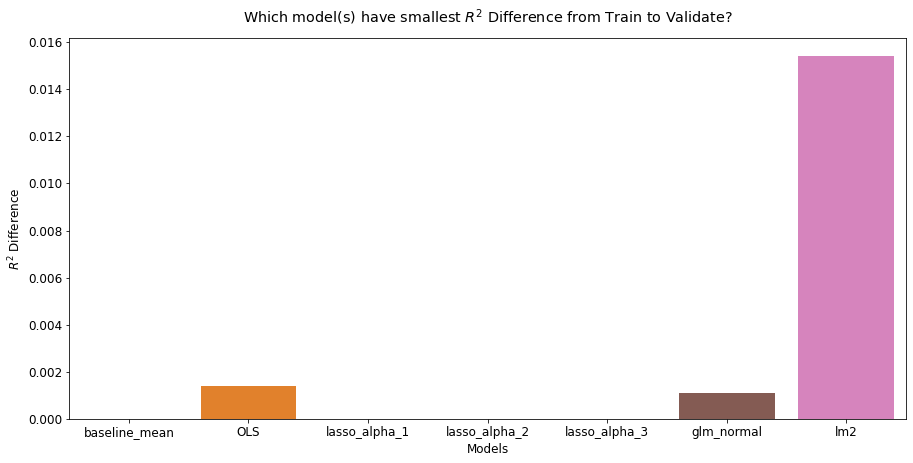

In [68]:
# Make a plot to visualize results
sns.barplot(y=metric_df.R2_diff, x=metric_df.model)
plt.title('Which model(s) have smallest $R^2$ Difference from Train to Validate?', pad=16)
plt.xlabel('Models')
plt.ylabel('$R^2$ Difference');

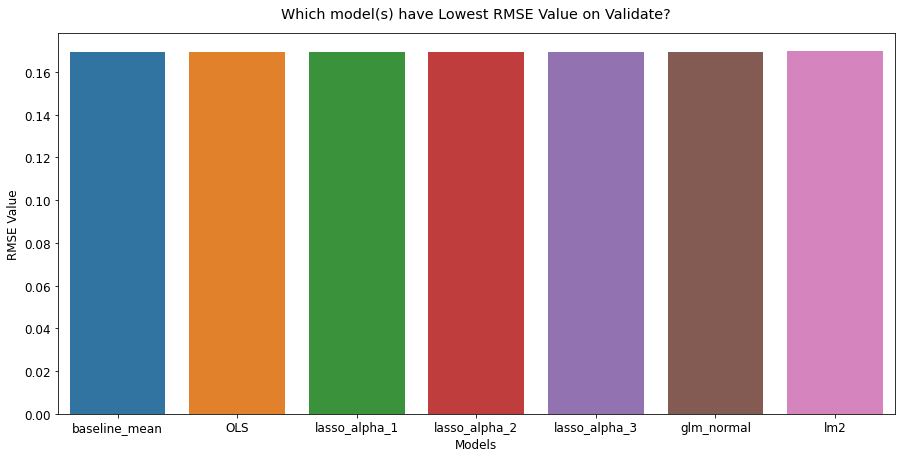

In [69]:
# Make a plot to visualize results
sns.barplot(y=metric_df.RMSE_validate, x=metric_df.model)
plt.title('Which model(s) have Lowest RMSE Value on Validate?', pad=16)
plt.xlabel('Models')
plt.ylabel('RMSE Value');

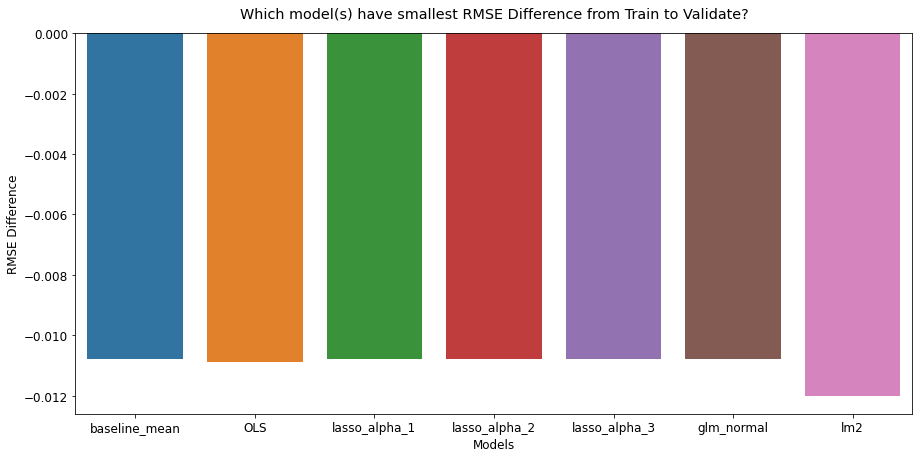

In [70]:
# Make a plot to visualize results
sns.barplot(y=metric_df.RMSE_diff, x=metric_df.model)
plt.title('Which model(s) have smallest RMSE Difference from Train to Validate?', pad=16)
plt.xlabel('Models')
plt.ylabel('RMSE Difference');

### Residual Plots

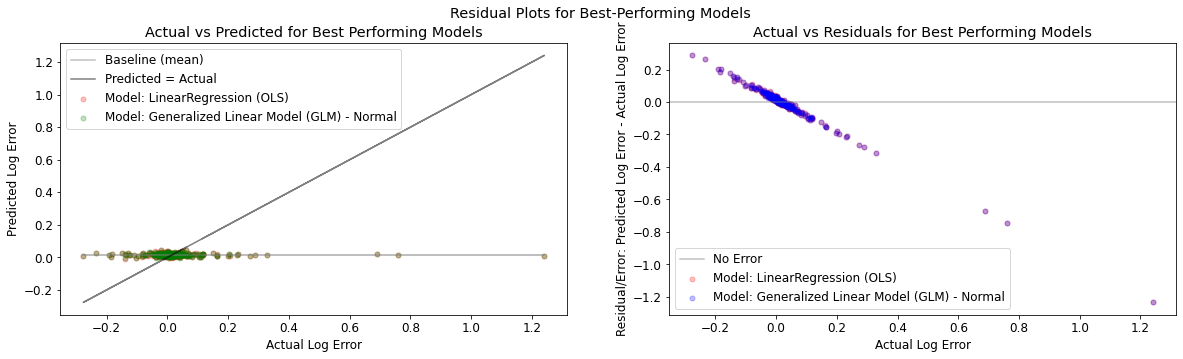

In [71]:
# create residual plots
# ols_y_pred, glm_y_pred_normal

plt.figure(figsize=(20,5)).suptitle('Residual Plots for Best-Performing Models')

plt.subplot(121)

plt.plot(y_validate.log_error.sample(n=250, random_state=527), y_validate.baseline_mean.sample(n=250, random_state=527), alpha=0.5, color="gray", label='Baseline (mean)')
plt.plot(y_validate.log_error.sample(n=250, random_state=527), y_validate.log_error.sample(n=250, random_state=527), alpha=0.5, color="black", label='Predicted = Actual')

plt.scatter(y_validate.log_error.sample(n=250, random_state=527), y_validate.ols_y_pred.sample(n=250, random_state=527), 
            alpha=.25, color="red", s=25, label="Model: LinearRegression (OLS)")
plt.scatter(y_validate.log_error.sample(n=250, random_state=527), y_validate.glm_y_pred_normal.sample(n=250, random_state=527), 
            alpha=.25, color="green", s=25, label="Model: Generalized Linear Model (GLM) - Normal")

plt.legend()
plt.xlabel("Actual Log Error")
plt.ylabel("Predicted Log Error")
plt.title("Actual vs Predicted for Best Performing Models")

plt.subplot(122)

plt.axhline(label="No Error", color='gray', alpha=0.5)
plt.scatter(y_validate.log_error.sample(n=250, random_state=527), (y_validate.ols_y_pred - y_validate.log_error).sample(n=250, random_state=527), 
            alpha=.25, color="red", s=25, label="Model: LinearRegression (OLS)")
plt.scatter(y_validate.log_error.sample(n=250, random_state=527), (y_validate.glm_y_pred_normal - y_validate.log_error).sample(n=250, random_state=527), 
            alpha=.25, color="blue", s=25, label="Model: Generalized Linear Model (GLM) - Normal")

plt.legend()
plt.xlabel("Actual Log Error")
plt.ylabel("Residual/Error: Predicted Log Error - Actual Log Error")
plt.title("Actual vs Residuals for Best Performing Models");

#### Takeaway:
- Best peforming model is GLM model since RMSE scores are all so similar and it has highest $R^2$ value on validate

### Evaluate Best-Performing Model (GLM Normal) on Test

In [72]:
y_test = pd.DataFrame(y_test)
y_test['baseline_mean'] = y_train.log_error.mean()

# predict on test
y_test['glm_y_pred_normal'] = glm.predict(X_test)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.log_error, y_test.glm_y_pred_normal, squared=False)
r2_test = explained_variance_score(y_test.log_error, y_test.glm_y_pred_normal)
rmse_baseline = mean_squared_error(y_test.log_error, y_test.baseline_mean, squared=False)
r2_baseline = explained_variance_score(y_test.log_error, y_test.baseline_mean)
pcnt_diff_rmse = (rmse_test - rmse_baseline)/((rmse_test + rmse_baseline)/2) * 100
pcnt_diff_r2 = (r2_test - r2_baseline)/((r2_test + r2_baseline)/2) * 100

print(f'RMSE for GLM Normal\nOut-of-Sample Performance: {rmse_test:.3f}\nR^2: {r2_test:.3f}')

RMSE for GLM Normal
Out-of-Sample Performance: 0.174
R^2: 0.002


**Compare to Baseline:**

In [73]:
print(f'Metrics for baseline:\nRMSE: {rmse_baseline:.3f}\nR^2: {r2_baseline:.3f}')

Metrics for baseline:
RMSE: 0.174
R^2: 0.000


In [74]:
print(f'Model outperformed best baseline:\nRMSE difference: {rmse_test - rmse_baseline:.4f}\nR^2 difference: \
{(r2_test - r2_baseline):.3f}')

Model outperformed best baseline:
RMSE difference: -0.0002
R^2 difference: 0.002


In [75]:
print(f'Percent difference of model compared to baseline:\nRMSE: {pcnt_diff_rmse:.3f}%\nR^2: {pcnt_diff_r2:.0f}%')

Percent difference of model compared to baseline:
RMSE: -0.102%
R^2: 200%


In [76]:
# discover which features were most important in the model
coef = pd.DataFrame(data={'glm_coef' : glm.coef_}, index = X_train.columns)
coef['abs_glm_coef'] = coef.glm_coef.apply(lambda x: x if x >= 0 else -x)
coef.sort_values(by='abs_glm_coef', ascending=False).head(7)

,glm_coef,abs_glm_coef
assessed_value_scaled,-0.025283,0.025283
latitude_scaled,-0.015975,0.015975
bed_cnt_scaled,0.013124,0.013124
_more_than_2500_sf,0.012593,0.012593
total_rooms_scaled,0.006680,0.006680
lot_sqft_scaled,-0.004717,0.004717
sqft_scaled,-0.004578,0.004578


## Conclusions and Next Steps

 **Conclusions/Takaways:**
- The following subgroups had higher than average log error: 
    - Orange County
    - above 2,500 square feet
    - below 250k dollars assessed value
    - 7 - 12 total rooms
    - cluster 4 from Cluster Model 1 (total rooms, sqft, assessed_value)
- Best predictors identified via modeling were:
    - assessed value
    - latitude
    - bedroom count
    - above 2,500 square feet
    - total rooms
    - lot size
    - livable square footage
- Best-peforming model only slightly outperformed baseline

**Next Steps/Recommendations:**
- Manually look into more subgroups to see if model is performing poorly on specific portions of the population
- Try more combinations of features in model to see if model performance can be improved/more drivers can be indentified
- Leverage clustering to create subgroups for other single continuous variables
- Try clustering on more combinations of features to see if more subgroups could be identified using algorithm
- Look into creating individual models for subgroups with higher error mentioned above